## Issues With Image Translation

In [1]:
from torchvision import datasets
import torch
import torch.nn as nn
from torch.utils.data import Dataset,DataLoader
from torch.optim import Adam
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
device='cuda' if torch.cuda.is_available() else 'cpu'
fmnist=datasets.FashionMNIST(r'../data',download=True,train=True)
val_fmnist=datasets.FashionMNIST(r'../data',download=True,train=False)
tr_images,tr_targets=fmnist.data,fmnist.targets
val_images,val_targets=val_fmnist.data,val_fmnist.targets

In [2]:
class FMNISTDataset(Dataset):
    def __init__(self,x,y):
        self.x,self.y=x.float().view(-1,28*28)/255,y
    def __getitem__(self, item):
        return self.x[item].to(device),self.y[item].to(device)
    def __len__(self):
        return len(self.x)

def get_model():
    model=nn.Sequential(
        nn.Linear(28*28,1000),
        nn.ReLU(),
        nn.Linear(1000,10)
    ).to(device)
    loss_fn=nn.CrossEntropyLoss()
    optimizer=Adam(model.parameters(),lr=1e-3)
    return model,loss_fn,optimizer

def train_batch(x,y,model,opt,loss_fn):
    model.train()
    batch_loss=loss_fn(model(x),y)
    batch_loss.backward()
    opt.step()
    opt.zero_grad()
    return batch_loss.item()

def accuracy(x,y,model):
    model.eval()
    with torch.no_grad():
        prediction=model(x)
    max_values,argmaxes=prediction.max(-1)
    is_correct=argmaxes==y
    return is_correct.cpu().numpy().tolist()

def get_data():
    train=FMNISTDataset(tr_images,tr_targets)
    trn_dl=DataLoader(train,batch_size=32,shuffle=True)
    val=FMNISTDataset(val_images,val_targets)
    val_dl=DataLoader(val,batch_size=len(val_images),shuffle=False)
    return trn_dl,val_dl

@torch.no_grad()
def val_loss(x,y,model,loss_fn):
    model.eval()
    val_loss=loss_fn(model(x),y)
    return val_loss.item()

In [3]:
trn_dl,val_dl=get_data()
model,loss_fn,optimizer=get_model()

In [4]:
train_losses,train_accuracies=[],[]
val_losses,val_accuracies=[],[]
for epoch in range(5):
    print(epoch)
    train_epoch_losses,train_epoch_accuraices=[],[]
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        batch_loss=train_batch(x,y,model,optimizer,loss_fn)
        train_epoch_losses.append(batch_loss)
    train_epoch_loss=np.array(train_epoch_losses).mean()
    for ix,batch in enumerate(iter(trn_dl)):
        x,y=batch
        is_correct=accuracy(x,y,model)
        train_epoch_accuraices.extend(is_correct)
    train_epoch_accuracy=np.mean(train_epoch_accuraices)
    for ix,batch in enumerate(iter(val_dl)):
        x,y=batch
        val_is_correct=accuracy(x,y,model)
        validation_loss=val_loss(x,y,model,loss_fn)
    val_epoch_accuracy=np.mean(val_is_correct)
    train_losses.append(train_epoch_loss)
    train_accuracies.append(train_epoch_accuracy)
    val_losses.append(validation_loss)
    val_accuracies.append(val_epoch_accuracy)

0
1
2
3
4


Text(0.5, 1.0, 'Trouser')

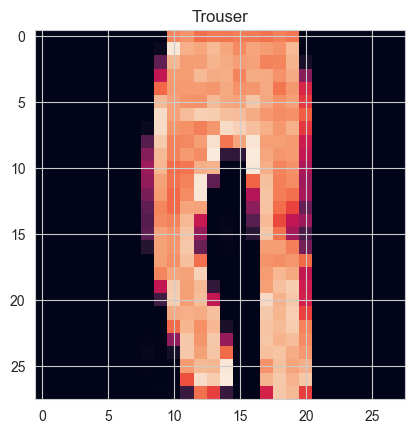

In [5]:
ix=24300
plt.imshow(tr_images[ix])
plt.title(fmnist.classes[tr_targets[ix]])

In [6]:
img=tr_images[ix].view(28*28).to(device)/255.

In [7]:
np_output=model(img).cpu().detach().numpy()
np.exp(np_output)/np.sum(np.exp(np_output))

array([2.5069786e-04, 9.9973977e-01, 1.4842842e-06, 1.0363767e-06,
       7.9516457e-07, 3.0787553e-09, 6.1956871e-06, 4.4415380e-16,
       8.8043466e-09, 1.1304041e-09], dtype=float32)

In [8]:
tr_targets[ix]

tensor(1)

torch.Size([28, 28])


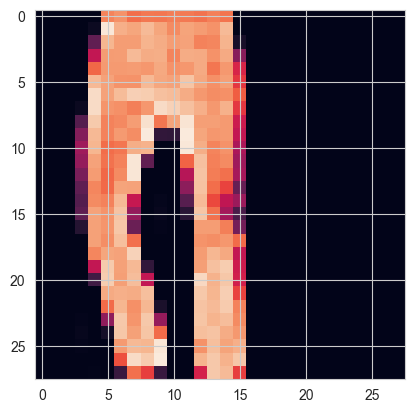

torch.Size([28, 28])


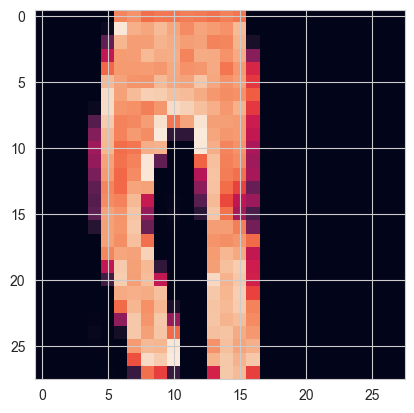

torch.Size([28, 28])


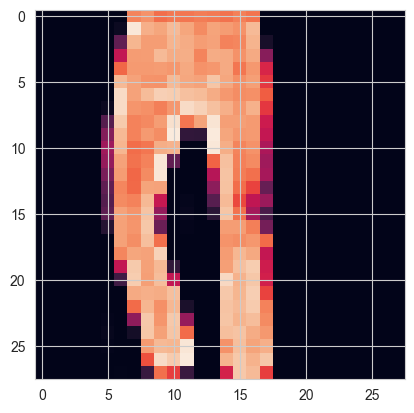

torch.Size([28, 28])


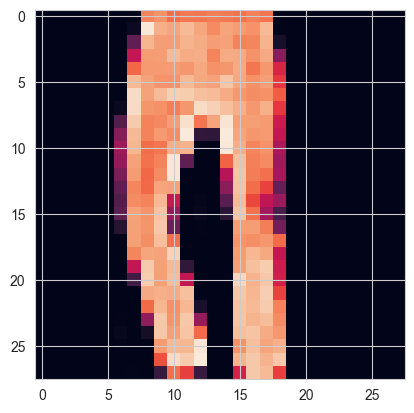

torch.Size([28, 28])


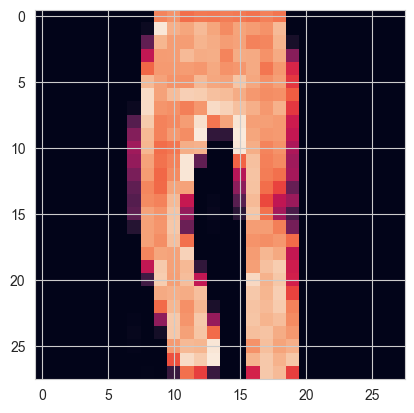

torch.Size([28, 28])


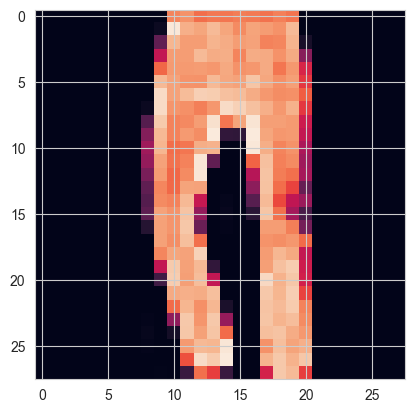

torch.Size([28, 28])


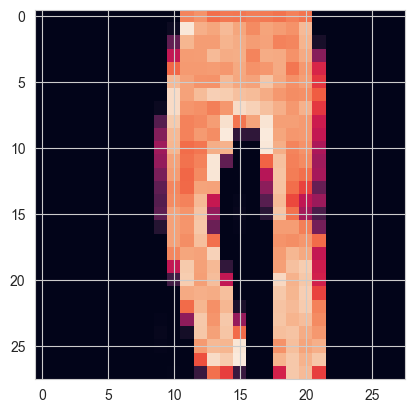

torch.Size([28, 28])


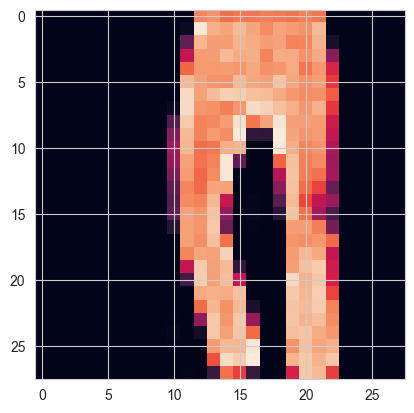

torch.Size([28, 28])


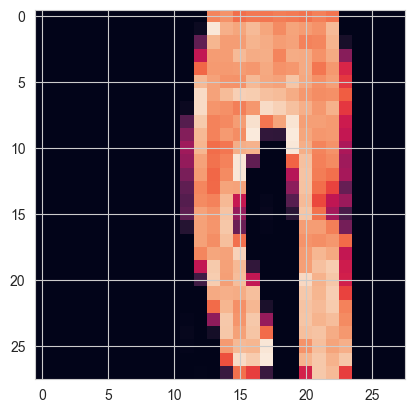

torch.Size([28, 28])


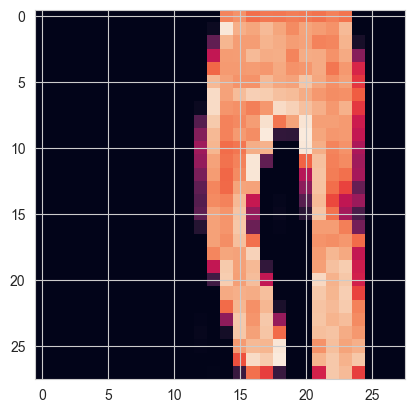

torch.Size([28, 28])


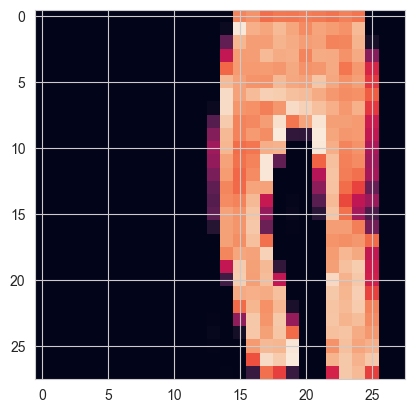

In [9]:
preds=[]
for px in range(-5,6):
    img=tr_images[ix]/255.
    img=img.view(28,28)
    print(img.shape)
    img2=np.roll(img,px,axis=1)
    plt.imshow(img2)
    plt.show()
    img3=torch.Tensor(img2).view(28*28).to(device)
    np_output=model(img3).cpu().detach().numpy()
    preds.append(np.exp(np_output)/np.sum(np.exp(np_output)))

<Axes: title={'center': 'Probability of each class for various translations'}>

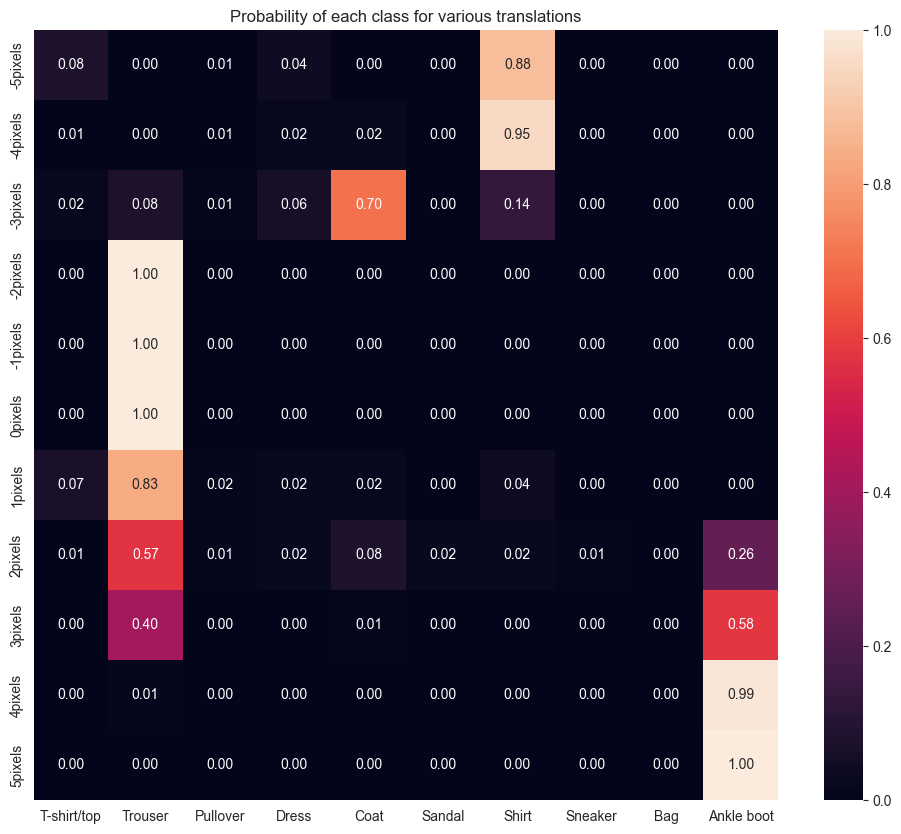

In [10]:
import seaborn as sns
fig,ax=plt.subplots(1,1,figsize=(12,10))
plt.title('Probability of each class for various translations')
sns.heatmap(np.array(preds),annot=True,ax=ax,fmt='.2f',xticklabels=fmnist.classes,yticklabels=[str(i)+str('pixels') for i in range(-5,6)])